# Experiment

In [1]:
# Script for generate  experiments
# Imports
from clases.red_rddas_model import RedRddasModel
import ray
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ray Configurations
ray.init(num_cpus=12, log_to_driver=False)

# Experiment for RDD variation
n_experiments = 3
l_experiments = []
for cont_experiment in range(1,n_experiments+1):
    print("============================")
    print("Experiment:", cont_experiment)
    print("============================")

    # Variable Parameters
    n_rddas_min = 3
    n_rddas_max = 12

    # Fixed Parameters
    n_of_variables_rdda = 5
    n_of_signals_rdda = 2
    n_exit_variables = 2
    n_clauses_function = 2
    type_network = "ALEATORY"
    # this name has to be unique
    unique_path = "21_01_2022"

    # List of Result for the Experiments
    l_res_experiment = []

    v_n_network = 1
    for n_of_rdds in range(n_rddas_min, n_rddas_max + 1):
        print("Number of Network:", v_n_network)
        print("-------------------------------")

        path = "files/" + unique_path + "_" + str(n_of_rdds) + "_" + str(n_of_variables_rdda) + "_" + str(n_of_signals_rdda) \
               + "_" + str(n_exit_variables) + "_" + str(n_clauses_function)

        # generate the RDDAs of the Network of RDDAs
        print("generating the Network of RDDAs ...")
        oRedRddasModel = RedRddasModel(n_of_rdds, n_of_variables_rdda, n_of_signals_rdda, n_exit_variables,
                                       n_clauses_function)

        # Generate the RDDs
        print("generating the rdds ...")
        oRedRddasModel.generate_rddas(type_network=type_network)

        # # Save the Network of RDDAs in a Pickle file
        # RedRddasModel.save_file_pickle(oRedRddasModel, path)
        # path += ".pickle"
        #
        # print("=======================================================")
        # print("The Network of RDDAs is saved in: ", path)

        # Show the Network of RDDAs
        # oRedRddasModel.show()

        # Calculate the Attractors by RDDA and by Signal
        result = RedRddasModel.find_attractors_rddas_ray.remote(oRedRddasModel)
        oRedRddasModel = ray.get(result)

        # Calculate the Attractors by RDDA and by Signal
        v_begin_0 = time.time()
        result = RedRddasModel.calculation_compatible_pairs.remote(oRedRddasModel)
        oRedRddasModel = ray.get(result)
        v_end_0 = time.time()
        v_time_0 = v_end_0 - v_begin_0

        # Calculate the Attractors by RDDA and by Signal with iterative Method
        v_begin_1 = time.time()
        # result = RedRddasModel.assembly_attractor_fields_iterative.remote(oRedRddasModel)
        # oRedRddasModel = ray.get(result)
        v_end_1 = time.time()
        v_time_1 = v_end_1 - v_begin_1

        v_begin_2 = time.time()
        # Calculate the Attractors by RDDA and by Signal with optimized Method
        result = RedRddasModel.assembly_attractor_fields_optimized.remote(oRedRddasModel)
        oRedRddasModel = ray.get(result)
        v_end_2 = time.time()
        v_time_2 = v_end_2 - v_begin_2

        res_dict = {"n_network": v_n_network,
                    "n_rdds": n_of_rdds,
                    "n_rdda_attractors": len(oRedRddasModel.d_global_rdda_attractor.items()),
                    "n_attractor_fields": len(oRedRddasModel.attractor_fields),
                    "t_comp_paris_method": v_time_0,
                    # "t_iterative_method": v_time_1,
                    "t_optimized_method": v_time_2,
                    }
        l_res_experiment.append(res_dict)
        v_n_network = v_n_network + 1

    for v_reg_dict in l_res_experiment:
        # Show the metrics
        print("===========================================")
        print("Result of Network:", v_reg_dict["n_network"])
        print("===========================================")
        print("Number of RDDs:", v_reg_dict["n_rdds"])
        print("Number of Attractors :", v_reg_dict["n_rdda_attractors"])
        print("Number of Attractor Fields:", v_reg_dict["n_attractor_fields"])
        print("Duration Compatible Pairs Method :", v_reg_dict["t_comp_paris_method"])
        # print("Duration Iterative Method :", v_reg_dict["t_iterative_method"])
        print("Duration Optimized Method:", v_reg_dict["t_optimized_method"])

    # Read  the Data
    df = pd.DataFrame.from_dict(l_res_experiment)
    l_experiments.append(df)
print("END EXPERIMENT")

Experiment: 1
Number of Network: 1
-------------------------------
generating the Network of RDDAs ...
generating the rdds ...
RDDA :  1
VARIABLES :  [1, 2, 3, 4, 5]
RDDA :  2
VARIABLES :  [6, 7, 8, 9, 10]
RDDA :  3
VARIABLES :  [11, 12, 13, 14, 15]
Generating the True Table
A ∨ B
{'9': 'A', '10': 'B'}
{'A': True, 'B': True}
A ∨ B
{'9': 'A', '10': 'B'}
{'A': True, 'B': False}
A ∨ B
{'9': 'A', '10': 'B'}
{'A': False, 'B': True}
A ∨ B
{'9': 'A', '10': 'B'}
{'A': False, 'B': False}
Network Input : 1
Network Output : 2
Variables : [9, 10]
Name Variable : 16
Coupling Function : 9 ∨ 10
Truth Table: {'11': '1', '10': '1', '01': '1', '00': '0'}
Generating the True Table
A ∨ B
{'14': 'A', '13': 'B'}
{'A': True, 'B': True}
A ∨ B
{'14': 'A', '13': 'B'}
{'A': True, 'B': False}
A ∨ B
{'14': 'A', '13': 'B'}
{'A': False, 'B': True}
A ∨ B
{'14': 'A', '13': 'B'}
{'A': False, 'B': False}
Network Input : 1
Network Output : 3
Variables : [14, 13]
Name Variable : 17
Coupling Function : 14 ∨ 13
Truth Table:

# Analysing the result

### Time vs RDDAs

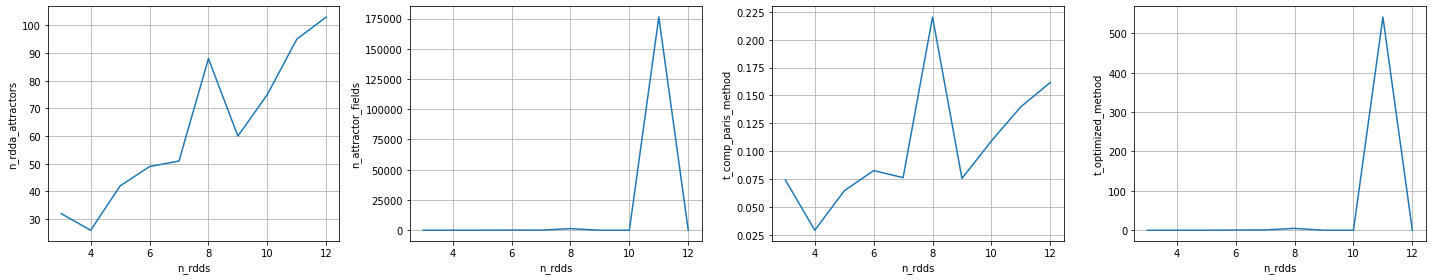

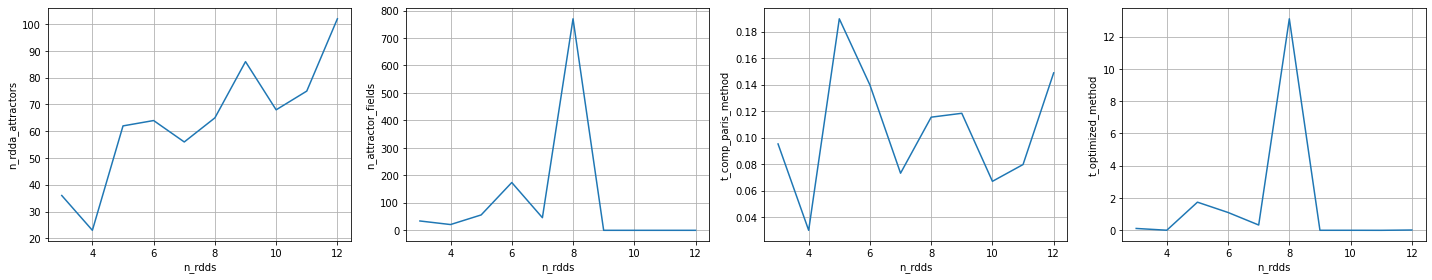

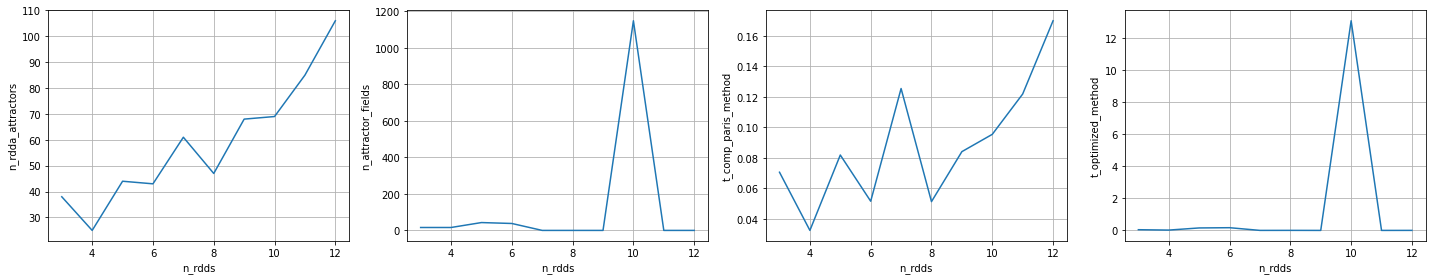

In [5]:
# Show the graphs for every experiment
for df in l_experiments:
    fig_, axs = plt.subplots(1,4,figsize=(20,4))
    for (ax, y) in zip(axs, np.asarray(df.keys())[2:]):
        ax.plot(df['n_rdds'], df[y])
        ax.set_xlabel('n_rdds')
        ax.set_ylabel(y)
        ax.grid(True)
    fig_.tight_layout()
    # df.plot(x='n_rdds', y='n_rdda_attractors', figsize=(10,8))

In [3]:


# x =
# y =
#
# fig, ax = plt.subplots()
# ax.plot(x, y)
# plt.show()


In [4]:


# x =
# y =
#
# fig, ax = plt.subplots()
# ax.plot(x, y)
# plt.show()
